In [189]:
### Make notebook wider:

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [30]:
### process LFP data in some way? extract LFP for each recording?
## maybe just for this first pass test it on one I have extracted already? 
### load in tracking data
### determine putative sleep timepoints
### load in LFP data and filter for eahc band 
### use this to do sleep state scoring
### save out sleep state scoring in a useable format.
## maybe use this saved out data to define PPSEQ timepoints? 



In [31]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import statistics
import json
from PIL import Image, ImageDraw, ImageFont
import seaborn as sns;
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from scipy.signal import savgol_filter
from scipy.signal import filtfilt
import scipy.stats as stats

def conactinate_nth_items(startlist):
    concatinated_column_vectors = []
    for c in range(len(max(startlist, key=len))):
        column = []
        for t in range(len(startlist)):
            if c <= len(startlist[t])-1:
                column = column + [startlist[t][c]]
        concatinated_column_vectors.append(column)
    return concatinated_column_vectors

def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name, bbox_inches='tight')
    plt.show()
    plt.close()

def find_largest_peaks_indices(arr, num_peaks=5):
    peaks = []

    # Check for peaks in the interior of the array
    for i in range(1, len(arr) - 1):
        if arr[i] > arr[i - 1] and arr[i] > arr[i + 1]:
            peaks.append(i)

    # Sort the peaks based on their values in descending order
    sorted_peaks = sorted(peaks, key=lambda x: arr[x], reverse=True)[:num_peaks]

    return sorted_peaks

def load_H5_bodypart(tracking_path,video_type, tracking_point):
    # Load in all '.h5' files for a given folder:
    TFiles_unsort = list_files(tracking_path, 'h5')

    for file in TFiles_unsort:
        print(file)
        if video_type in file:
            if 'above' in file:
                back_file = pd.read_hdf(tracking_path + file)          
    # drag data out of the df
    scorer = back_file.columns.tolist()[0][0]
    body_part = back_file[scorer][tracking_point]
    
    parts=[]
    for item in list(back_file[scorer]):
        parts+=[item[0]]
    print(np.unique(parts))
    # clean and interpolate frames with less than 98% confidence
    clean_and_interpolate(body_part,0.98)
    return(body_part)

def clean_and_interpolate(head_centre,threshold):
    bad_confidence_inds = np.where(head_centre.likelihood.values<threshold)[0]
    newx = head_centre.x.values
    newx[bad_confidence_inds] = 0
    newy = head_centre.y.values
    newy[bad_confidence_inds] = 0

    start_value_cleanup(newx)
    interped_x = interp_0_coords(newx)

    start_value_cleanup(newy)
    interped_y = interp_0_coords(newy)
    
    head_centre['interped_x'] = interped_x
    head_centre['interped_y'] = interped_y
    
def start_value_cleanup(coords):
    # This is for when the starting value of the coords == 0; interpolation will not work on these coords until the first 0 
    #is changed. The 0 value is changed to the first non-zero value in the coords lists
    for index, value in enumerate(coords):
        working = 0
        if value > 0:
            start_value = value
            start_index = index
            working = 1
            break
    if working == 1:
        for x in range(start_index):
            coords[x] = start_value
    
def list_files(directory, extension):
    return (f for f in os.listdir(directory) if f.endswith('.' + extension))

def interp_0_coords(coords_list):
    #coords_list is one if the outputs of the get_x_y_data = a list of co-ordinate points
    for index, value in enumerate(coords_list):
        if value == 0:
            if coords_list[index-1] > 0:
                value_before = coords_list[index-1]
                interp_start_index = index-1
                #print('interp_start_index: ', interp_start_index)
                #print('interp_start_value: ', value_before)
                #print('')

        if index < len(coords_list)-1:
            if value ==0:
                if coords_list[index+1] > 0:
                    interp_end_index = index+1
                    value_after = coords_list[index+1]
                    #print('interp_end_index: ', interp_end_index)
                    #print('interp_end_value: ', value_after)
                    #print('')

                    #now code to interpolate over the values
                    try:
                        interp_diff_index = interp_end_index - interp_start_index
                    except UnboundLocalError:
#                         print('the first value in list is 0, use the function start_value_cleanup to fix')
                        break
                    #print('interp_diff_index is:', interp_diff_index)

                    new_values = np.linspace(value_before, value_after, interp_diff_index)
                    #print(new_values)

                    interp_index = interp_start_index+1
                    for x in range(interp_diff_index):
                        #print('interp_index is:', interp_index)
                        #print('new_value should be:', new_values[x])
                        coords_list[interp_index] = new_values[x]
                        interp_index +=1
        if index == len(coords_list)-1:
            if value ==0:
                for x in range(30):
                    coords_list[index-x] = coords_list[index-30]
                    #print('')
#     print('function exiting')
    return(coords_list)

def calculate_velocity(x, y, time_interval=1):
    # Calculate displacement
    dx = np.diff(x)
    dy = np.diff(y)

    # Calculate time elapsed
    dt = time_interval * np.ones_like(dx)  # Assuming constant time interval

    # Calculate velocity
    velocity_x = dx / dt
    velocity_y = dy / dt

    return velocity_x, velocity_y

def calculate_2d_velocity(x, y, time_interval=1):
    # Calculate velocity components
    vx, vy = calculate_velocity(x, y, time_interval)

    # Calculate 2D velocity
    velocity_2d = np.sqrt(vx**2 + vy**2)

    return velocity_2d

def list_all_datapaths(data_path):
    data_paths = []
    for file in os.listdir(data_path):
        if 'EJT' in file[0:5]:
            for file_ in os.listdir(data_path+file):
                if 'record' in file_:
                    data_paths += [data_path+file+'\\'+file_]
    return data_paths

# Function to calculate average velocity per 10 seconds
def calculate_average_velocity(velocities, fps=60, interval_seconds=10):
    frames_per_interval = fps * interval_seconds
    num_intervals = len(velocities) // frames_per_interval

    average_velocities = []

    for i in range(num_intervals):
        start_index = i * frames_per_interval
        end_index = start_index + frames_per_interval

        interval_velocities = velocities[start_index:end_index]
        average_velocity = sum(interval_velocities) / frames_per_interval

        average_velocities.append(average_velocity)

    return average_velocities

def split_into_segments(data, sample_rate, segment_duration):
    # Calculate the number of samples per segment
    samples_per_segment = int(sample_rate * segment_duration)

    # Calculate the total number of segments
    num_segments = len(data) // samples_per_segment

    # Truncate the data to ensure it's a multiple of samples_per_segment
    data = data[:num_segments * samples_per_segment]

    # Reshape the data into segments
    segments = data.reshape((num_segments, samples_per_segment))

    return segments


fs = 2500

# load in data

In [17]:
# define paths:

data_path = r'Z:\projects\sequence_squad\organised_data\animals\\'
dat_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\striatum\New_Post_sleep\\"

sleep_time_point_df = pd.read_csv(dat_path + 'sleep_time_points.csv')

# list out all possible datapaths
data_paths = list_all_datapaths(data_path) 

In [19]:
mouse_index = 1

for path in data_paths:
    
    print('-------------------------------------')
    
#     print(path)
    
    a = path.split('\\')[-2].split('_')[0][3::]
    b = path.split('\\')[-2][-1]
    c = path.split('\\')[-1].split('_')[0][-1]
    current_mouse = '_'.join([a,b,c])
#     print(current_mouse)



    for index, path_ in enumerate(data_paths):

        mir = path_.split('\\')[-2].split('_')[0][3::] + '_' +  path_.split('\\')[-2].split('_')[1][-1] + '_' + path_.split('\\')[-1].split('_')[0][-1]
        if mir == current_mouse:
            print(mir)
            recording_date = path_.split('\\')[-1].split('_')[-1]
            org_data_path = path_
            m_index = index

    print(org_data_path)
    mouse_df = pd.DataFrame({})
    if os.path.exists(org_data_path + r"\ephys\LFP\\"):    
        if os.path.exists(org_data_path + r"\ephys\LFP\\" + 'df_downsampled.csv'):
            print('other loaded data')
            mouse_df = pd.read_csv(org_data_path + r"\ephys\LFP\\" + 'df_downsampled.csv')
        else:
            for LFP_file in os.listdir(org_data_path + r"\ephys\LFP\\"):
                if 'channel' in LFP_file:
                    name = 'channel-' + LFP_file.split('-')[1].split('_')[0] + '_' + LFP_file.split('-')[-1].split('_')[0]
                    LFP_channel_data = np.load(org_data_path + r"\ephys\LFP\\"+LFP_file)
                    mouse_df[name] = LFP_channel_data

                if 'aligned_LFP_timestamps' in LFP_file:
                    LFP_ts = np.load(org_data_path + r"\ephys\LFP\\"+LFP_file) 
    print(m_index)                
    if m_index == mouse_index:
        break
                    
      


-------------------------------------
136_1_2
Z:\projects\sequence_squad\organised_data\animals\\EJT136_implant1\recording2_10-11-2021
0
-------------------------------------
136_1_3
Z:\projects\sequence_squad\organised_data\animals\\EJT136_implant1\recording3_11-11-2021
1


In [20]:
## load in video tracking
animal_dat_path = r'Z:\projects\sequence_squad\organised_data\animals\\'

## find camera file and sync file: 
for item in os.listdir(animal_dat_path):
    if current_mouse.split('_')[0] in item:
        if current_mouse.split('_')[1] == item[-1]:
            for folder in os.listdir(animal_dat_path + item):
                if folder.split('_')[0][-1] == current_mouse.split('_')[-1]:
                    current_animals_video_path = os.path.join(animal_dat_path + item,folder)+ r"\\video\tracking\\"
                    current_animals_behav_sync_path = os.path.join(animal_dat_path + item,folder)+ r"\\behav_sync\\"
                    for stage in os.listdir(current_animals_video_path):
                        if 'postsleep' in stage:
                            tracking_path = current_animals_video_path + stage + '\\'
                            sync_path = current_animals_behav_sync_path + stage.split('t')[0] + 't' + '_' + stage.split('t')[-1] + '\\'
                            
above_body_centre = load_H5_bodypart(tracking_path,'above','body_centre')
above_left_ear = load_H5_bodypart(tracking_path,'above','left_ear')
above_right_ear = load_H5_bodypart(tracking_path,'above','right_ear')

sync_df = pd.read_csv(sync_path + r'Postsleep_Ephys_Camera_sync.csv')

bc_velocity = calculate_2d_velocity(above_body_centre.interped_x.values,above_body_centre.interped_y.values)
le_velocity = calculate_2d_velocity(above_left_ear.interped_x.values,above_left_ear.interped_y.values)
re_velocity = calculate_2d_velocity(above_right_ear.interped_x.values,above_right_ear.interped_y.values)

above_2021-11-11T16_33_43DLC_resnet50_sleep-tracking_above-viewApr5shuffle1_500000.h5
['body_centre' 'implant_centre' 'left_ear' 'right_ear' 'tail_base']
above_2021-11-11T16_33_43DLC_resnet50_sleep-tracking_above-viewApr5shuffle1_500000.h5
['body_centre' 'implant_centre' 'left_ear' 'right_ear' 'tail_base']
above_2021-11-11T16_33_43DLC_resnet50_sleep-tracking_above-viewApr5shuffle1_500000.h5
['body_centre' 'implant_centre' 'left_ear' 'right_ear' 'tail_base']


avaerage tracking and determine sleep/non move times 

Text(0.5, 1.0, 'highlighted = sleep')

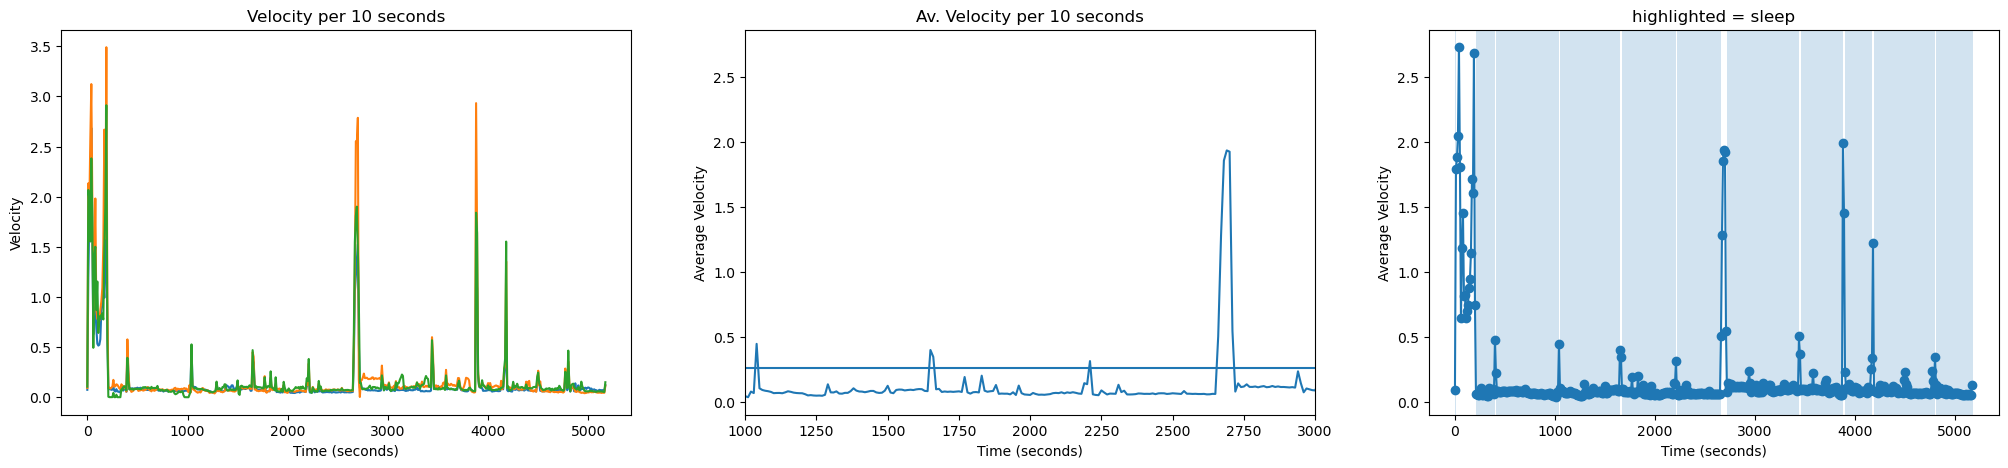

In [21]:
# 10s average
bc_av_velocities  = calculate_average_velocity(bc_velocity)
le_av_velocities  = calculate_average_velocity(le_velocity)
re_av_velocities  = calculate_average_velocity(re_velocity)

time_points = [i * 10 for i in range(len(bc_av_velocities))]  # Time points in seconds

fig, axs = plt.subplots(1, 3,figsize=(25, 5))

axs[0].plot(time_points, bc_av_velocities)
axs[0].plot(time_points, le_av_velocities)
axs[0].plot(time_points, re_av_velocities)
axs[0].set_xlabel('Time (seconds)')
axs[0].set_ylabel('Velocity')
axs[0].set_title('Velocity per 10 seconds')


#average between them:
average_velocity = [np.mean(item) for item in conactinate_nth_items([bc_av_velocities]+[le_av_velocities]+[re_av_velocities])]
axs[1].plot(time_points, average_velocity)
axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('Average Velocity')
axs[1].set_title('Av. Velocity per 10 seconds')
axs[1].set_xlim(1000,3000)


## decide what counts as movement, 0.8*std because why not...? 
movement_threshold = 0.8*np.std(average_velocity)

axs[1].axhline(movement_threshold)

movement = []
for index,velo in enumerate(average_velocity):
    if velo < movement_threshold:
        axs[2].axvspan(time_points[index],time_points[index]+10, alpha = 0.2)
        movement+=[0]
    else:
        movement+=[1]
axs[2].plot(time_points, average_velocity, 'o-')
axs[2].set_xlabel('Time (seconds)')
axs[2].set_ylabel('Average Velocity')
axs[2].set_title('highlighted = sleep')


select electrodes

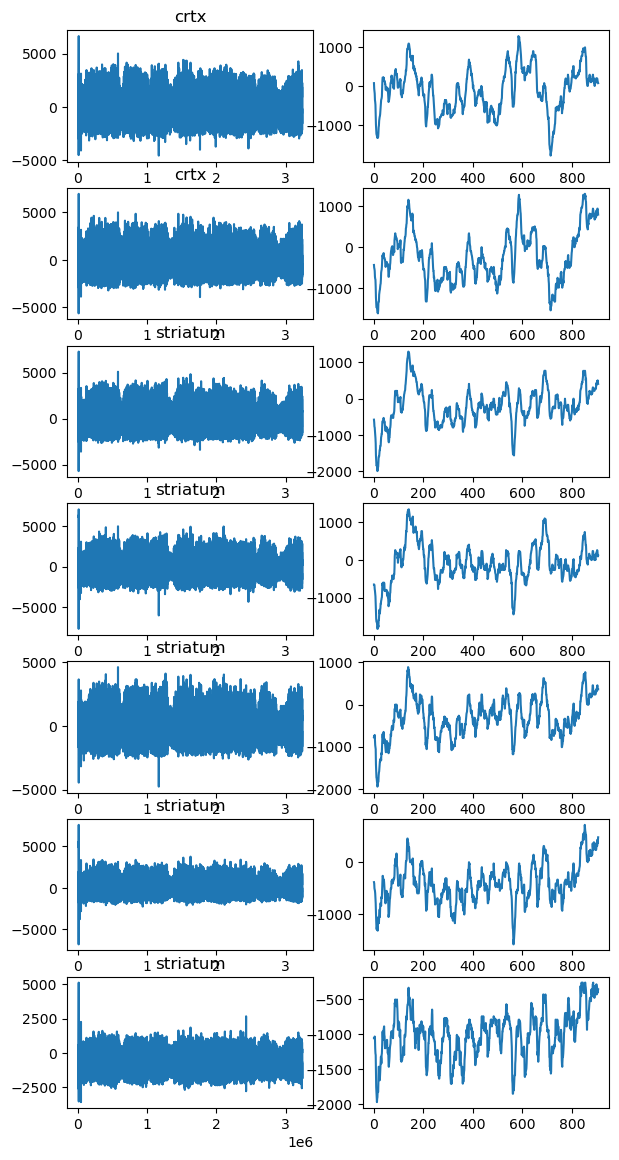

In [22]:
#manual rejection of noisy electrodes 
#extract and reorder channels:
channels = []
channel_num = []
channel_lst = list(mouse_df)
for item in channel_lst:
    if 'channel' in item:
        channels += [item]
        channel_num += [int(item.split('-')[-1].split('_')[0])]
channels = list(np.array(channels)[np.argsort(channel_num)])
channels = channels[::-1]

## chop down data to only the relevant sleep time 
start = sync_df.Camera_time_Ephys_Aligned.values[0]
end = sync_df.Camera_time_Ephys_Aligned.values[-1]
mouse_df['time_stamps'] = mouse_df.index.values * (1/fs)
chopped_mask = (mouse_df.time_stamps.values >= start)*(mouse_df.time_stamps.values <= end)

chopped_mouse_df= pd.DataFrame({})
fig, axs = plt.subplots(7, 2, figsize=(7, 14))  # 2 rows, 1 column
for i,chan in enumerate(channels):
    chopped_mouse_df[chan] = mouse_df[chan][chopped_mask]
    ## [::4] this means we only take every 2nd item - essentially downsampling to make it faster
    axs[i][0].plot(chopped_mouse_df[chan].values[::4])
    axs[i][0].set_title(chan.split('_')[-1])
    
    cut_down_data = chopped_mouse_df[chan].values[int(len(chopped_mouse_df[chan].values)*0.3):int(len(chopped_mouse_df[chan].values)*0.30007)]
    axs[i][1].plot(cut_down_data)


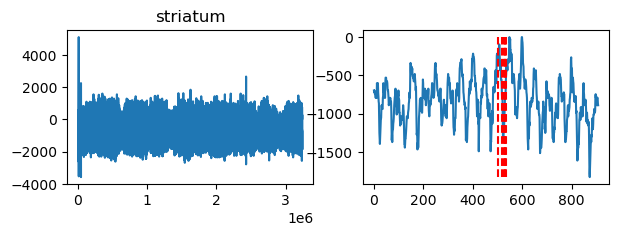

In [23]:
### choose channels 
chosen_channels_bool = [0,0,1,1,1,1,1]

#z-scoring of each electrode’s signal across the entire recording session. 
# A mean LFP signal was then generated by averaging across chosen electrodes. 
##### chose channels and average 
import scipy
## z score chosen chanels and average them. 
channel_z = []
for item in channels[min(np.where(np.array(chosen_channels_bool) == 1)[0]):max(np.where(np.array(chosen_channels_bool) == 1)[0])+1]:
    channel_z += [scipy.stats.zscore(chopped_mouse_df[item].values)]
lfp_all = np.vstack(channel_z)

# Avg all channels
average_lfp = lfp_all.mean(axis=0) # AVG

fig, axs = plt.subplots(1, 2, figsize=(7, 2))  # 2 rows, 1 column
## [::4] this means we only take every 2nd item - essentially downsampling to make it faster
axs[0].plot(chopped_mouse_df[chan].values[::4])
axs[0].set_title(chan.split('_')[-1])

cut_down_data = chopped_mouse_df[chan].values[int(len(chopped_mouse_df[chan].values)*0.7):int(len(chopped_mouse_df[chan].values)*0.70007)]
peaks = find_largest_peaks_indices(convolve_movmean(cut_down_data,200))
axs[1].plot(cut_down_data)
# Plot vertical lines at the positions of the peakiest peaks
for peak_index in peaks:
    axs[1].vlines(peak_index, ymin=min(cut_down_data), ymax=max(cut_down_data), color='red', linestyle='--')

calaculate spectral density and ratios

In [24]:
# segmented into non-overlapping 10 s windows.
# Call the function to get the segments
segments = split_into_segments(average_lfp, 2500, 10)


# In each window, the power spectral density was computed using the Chronux function mtspecgramc. Delta power (1–4 Hz) and theta ratio (5–10 Hz/2–15 Hz) were computed and used for behavioral state classification.
from tqdm import tqdm
import mne
delta_psds = []
theta_psds = []
theta_ratio = []
for i in tqdm(range(len(segments))):
    segment = segments[i]
    delta_psd,freqs = mne.time_frequency.psd_array_multitaper(segment,2500, fmin=1, fmax=4,verbose='WARNING')
    mean_delta = np.mean(delta_psd)
    delta_psds += [mean_delta]
    
    broad_psd,freqs = mne.time_frequency.psd_array_multitaper(segment,2500, fmin=2, fmax=15,verbose='WARNING')
    mean_broad = np.mean(broad_psd)
    
    theta_psd,freqs = mne.time_frequency.psd_array_multitaper(segment,2500, fmin=5, fmax=10,verbose='WARNING')
    mean_theta = np.mean(theta_psd)
    theta_psds += [mean_theta]
    
    # average theta power as a ratio of background power in a broader range (ie. how much of broad spectral power is accounted for by theta)
    theta_ratio += [mean_theta/mean_broad]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 518/518 [03:13<00:00,  2.68it/s]


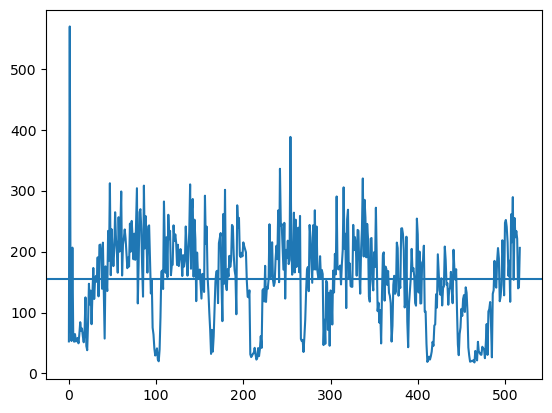

In [25]:
# epochs with high delta power (greater than mean delta) and no movement were classified as NREM
nrem = []
for index,event in enumerate(delta_psds):
    if event >= np.mean(delta_psds):
        if movement[index] == 0:
            nrem+=[1]
        else:
            nrem+=[0] 
    else:
        nrem+=[0]
        
plt.plot(delta_psds)
plt.axhline(np.mean(delta_psds))

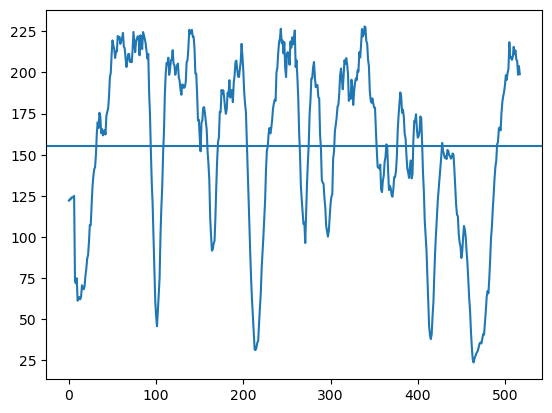

In [26]:
plt.plot(convolve_movmean(delta_psds,10))
plt.axhline(np.mean(delta_psds))

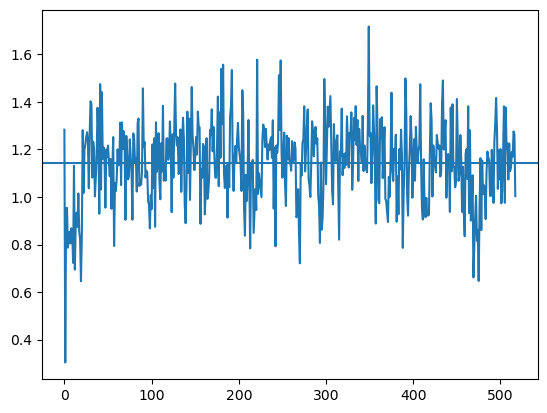

In [27]:
# epochs with high theta ration (greater than mean theta) and low delta power (less than mean delta) were classified as REM and no movement
rem = []
for index,event in enumerate(delta_psds):
    if event < np.mean(delta_psds):
        if theta_ratio[index] > np.mean(theta_ratio):
            if movement[index] == 0:
                rem+=[1]
            else:
                rem+=[0]
        else:
            rem+=[0]
    else:
        rem+=[0]
        
plt.plot(theta_ratio)
plt.axhline(np.mean(theta_ratio))

In [28]:
## all other epochs were classified as wake. All consecutive NREM or REM epochs that were less than 60 s long (six consecutive epochs) were reclassified as wake.

def cumsum_reset_on_zero(lst):
    result = []
    current_sum = 0

    for num in lst:
        if num == 0:
            current_sum = 0
        else:
            current_sum += num
        result.append(current_sum)

    return result

def wake_if_not_cumulative(nrem,wake,cumulative_needed):
    reset_cumsum = cumsum_reset_on_zero(nrem)
    for index,item in enumerate(reset_cumsum):
        if not item == 0 and reset_cumsum[index+1] == 0:
            if item < 6:
                if item > 1:
                    nrem[(index-(item-1)):index+1] = [0]*item
                    wake[(index-(item-1)):index+1] = [1]*item
                else:
                    nrem[index] = 0
                    wake[index] = 1
                    
    return nrem, wake

wake = []
for i in range(len(rem)):
    if rem[i] == 1 and nrem[i] == 1:
        print('error')
        
    if rem[i] == 0 and nrem[i] == 0:
        wake +=[1]
    else:
        wake +=[0]
    
    
nrem, wake =  wake_if_not_cumulative(nrem,wake,cumulative_needed=6)
rem, wake =  wake_if_not_cumulative(rem,wake,cumulative_needed=6)  

IndexError: list index out of range

In [ ]:
fig, axs = plt.subplots(1, 1,figsize=(15, 5))
axs.plot(average_velocity, '-')
axs.plot(nrem,c = 'g')
axs.plot(rem)

In [ ]:
fig, [ax1,ax2,ax3] = plt.subplots(3, 1,figsize=(25, 5))
ax1.plot(delta_psds, c = 'k')
ax1.set_title('blue = NREM    |   red = REM')
ax1.set_ylabel('delta power')
ax2.plot(theta_ratio, c = 'k')
ax2.set_ylabel('theta ratio')
ax3.plot(average_velocity, c = 'k')
ax3.set_xlabel('time (10s of seconds)')
ax3.set_ylabel('movement')

for i, value in enumerate(nrem):
    if value == 1:
        ax1.axvspan(i - 0.5, i + 0.5, facecolor='blue', alpha=0.2)
        ax2.axvspan(i - 0.5, i + 0.5, facecolor='blue', alpha=0.2)
        ax3.axvspan(i - 0.5, i + 0.5, facecolor='blue', alpha=0.2)
for i, value in enumerate(rem):
    if value == 1:
        ax1.axvspan(i - 0.5, i + 0.5, facecolor='red', alpha=0.2)
        ax2.axvspan(i - 0.5, i + 0.5, facecolor='red', alpha=0.2)
        ax3.axvspan(i - 0.5, i + 0.5, facecolor='red', alpha=0.2)


In [ ]:
## save this stuff out 

In [ ]:
#mean LFP signal was then segmented into non-overlapping 10 s windows





In each window, the power spectral density was computed using the Chronux function mtspecgramc. Delta power (1–4 Hz) and theta ratio (5–10 Hz/2–15 Hz) were computed and used for behavioral state classification.

In [ ]:
# manual rejection of noisy electrodes and z-scoring of each electrode’s signal across the entire recording session. A mean LFP signal was then generated in M1 for sleep classification by averaging across all M1 electrodes. 


This mean M1 LFP signal was then segmented into non-overlapping 10 s windows. In each window, the power spectral density was computed using the Chronux function mtspecgramc. Delta power (1–4 Hz) and theta ratio (5–10 Hz/2–15 Hz) were computed and used for behavioral state classification.


epochs with high delta power (greater than mean delta) and no movement were classified as NREM, epochs with high theta ration (greater than mean theta) and low delta power (less than mean delta) were classified as REM, and all other epochs were classified as wake. All consecutive NREM or REM epochs that were less than 60 s long (six consecutive epochs) were reclassified as wake.
